# Compare Hashing with FAISS

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
# System imports
import os
import sys
from time import time as tt
import importlib

# External imports
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torch_geometric.data import DataLoader

from itertools import chain
from random import shuffle, sample
from scipy.optimize import root_scalar as root

from torch.nn import Linear
import torch.nn.functional as F
from torch_cluster import knn_graph, radius_graph
import trackml.dataset
import torch_geometric
from itertools import permutations
import itertools
from sklearn import metrics
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import WandbLogger
from torch.utils.checkpoint import checkpoint

import faiss

sys.path.append('/global/homes/d/danieltm/ExaTrkX/Tracking-ML-Exa.TrkX/src/Pipelines/TrackML_Example')
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
from LightningModules.Embedding.utils import filter_hit_pt, fetch_pt, fetch_type, load_dataset, graph_intersection, build_edges

# Bucketing/Hashing Explore

## KeOps

In [4]:
!module load cudatoolkit/10.2.89_3.28-7.0.1.1_2.1__g88d3d59

In [2]:
import pykeops
pykeops.clean_pykeops()          # just in case old build files are still present
pykeops.test_torch_bindings()    # perform the compilation

Cleaning /global/u2/d/danieltm/.cache/pykeops-1.5-cpython-37-gpu0/...
    - /global/u2/d/danieltm/.cache/pykeops-1.5-cpython-37-gpu0/libKeOpstorch81e422afc4 has been removed.
    - /global/u2/d/danieltm/.cache/pykeops-1.5-cpython-37-gpu0/build-b05ab2324d has been removed.
    - /global/u2/d/danieltm/.cache/pykeops-1.5-cpython-37-gpu0/keops_hash.log has been removed.
    - /global/u2/d/danieltm/.cache/pykeops-1.5-cpython-37-gpu0/build-c75dc5d853 has been removed.
    - /global/u2/d/danieltm/.cache/pykeops-1.5-cpython-37-gpu0/build-pybind11_template-libKeOps_template_90eb971f10 has been removed.
    - /global/u2/d/danieltm/.cache/pykeops-1.5-cpython-37-gpu0/build-pybind11_template-libKeOps_template_479aecd36f has been removed.
[pyKeOps] Initializing build folder for dtype=float32 and lang=torch in /global/u2/d/danieltm/.cache/pykeops-1.5-cpython-37-gpu0 ... done.
[pyKeOps] Compiling libKeOpstorch81e422afc4 in /global/u2/d/danieltm/.cache/pykeops-1.5-cpython-37-gpu0:
       formula: Sum_R

[pyKeOps] Compiling pybind11 template libKeOps_template_90eb971f10 in /global/u2/d/danieltm/.cache/pykeops-1.5-cpython-37-gpu0 ... -- The CXX compiler identification is GNU 7.4.1
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Looking for a CUDA compiler
-- Looking for a CUDA compiler - NOTFOUND
-- No CUDA support
-- pybind11 v2.6.1 
-- Found PythonInterp: /global/homes/d/danieltm/.conda/envs/exatrkx-test/bin/python (found suitable version "3.7.7", minimum required is "3.7") 
-- Found PythonLibs: /global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/libpython3.7m.so
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- Configuring done
-- Generating done
-- Build files have been written to: /global/u2/d/danieltm/.cache/pykeops-1.5-cpython-37-gpu0/build-pybind11_t

RuntimeError: [KeOps] This KeOps shared object has been compiled without cuda support: 
 1) to perform computations on CPU, simply set tagHostDevice to 0
 2) to perform computations on GPU, please recompile the formula with a working version of cuda.

In [4]:
import pykeops
from pykeops.torch import LazyTensor

In [5]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

In [6]:
d = 2                           # dimension
nb = 10000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).type(dtype)

In [7]:
M = 1000 if use_cuda else 100
tmp = torch.linspace(0, 1, M).type(dtype)
g2, g1 = torch.meshgrid(tmp, tmp)
g = torch.cat((g1.contiguous().view(-1, 1), g2.contiguous().view(-1, 1)), dim=1)

In [8]:
G_i = LazyTensor(g[:, None, :])  # (M**2, 1, 2)
X_j = LazyTensor(xb[None, :, :])  # (1, N, 2)
D_ij = ((G_i - X_j) ** 2).sum(-1)  # (M**2, N) symbolic matrix of squared distances
indKNN = D_ij.argKmin(1, dim=1)  # Grid <-> Samples, (M**2, K) integer tensor

RuntimeError: [KeOps] This KeOps shared object has been compiled without cuda support: 
 1) to perform computations on CPU, simply set tagHostDevice to 0
 2) to perform computations on GPU, please recompile the formula with a working version of cuda.

In [ ]:
indKNN

In [86]:
d = 2                           # dimension
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.rand(nb, d).to(0)

In [87]:
num_nb = 100
K = int(nb / num_nb)

In [88]:
cl = torch.randint(0, K, (nb,)).to(0)
c = torch.rand(K, d).to(0)

In [89]:
xb

tensor([[0.4288, 0.3445],
        [0.1214, 0.5917],
        [0.7262, 0.2054],
        ...,
        [0.7788, 0.3213],
        [0.5778, 0.9420],
        [0.2007, 0.7922]], device='cuda:0')

In [34]:
test = torch.tensor([0, 3, 1, 1, 0, 3])

In [92]:
%%time
cl_indices = torch.argsort(cl)

CPU times: user 302 µs, sys: 310 µs, total: 612 µs
Wall time: 381 µs


In [51]:
cl_indices

tensor([26740, 82431, 42013,  ..., 18735, 68340, 35830])

In [93]:
%%time
cl_sorted = cl[cl_indices]

CPU times: user 71 µs, sys: 74 µs, total: 145 µs
Wall time: 150 µs


In [95]:
%%time
_, counts = torch.unique(cl_sorted, return_counts=True, sorted=True)

CPU times: user 621 µs, sys: 646 µs, total: 1.27 ms
Wall time: 939 µs


In [98]:
%%time
cl_indices_split =  cl_indices.split(tuple(counts))

CPU times: user 15.5 ms, sys: 0 ns, total: 15.5 ms
Wall time: 14.9 ms


In [107]:
%%time
buckets = []
for bucket in cl_indices_split:
    buckets.append(torch.combinations(bucket))

CPU times: user 291 ms, sys: 10 ms, total: 301 ms
Wall time: 510 ms


In [108]:
%%time
buckets = torch.combinations(cl_indices_split[0])
for bucket in cl_indices_split[1:]:
    torch.cat([buckets, torch.combinations(bucket)])

CPU times: user 304 ms, sys: 19.6 ms, total: 324 ms
Wall time: 460 ms


In [103]:
%%time
buckets_cat = torch.cat(buckets).t()

CPU times: user 0 ns, sys: 6.27 ms, total: 6.27 ms
Wall time: 5.75 ms


In [104]:
%%time
dist = torch.sum((xb[buckets_cat[0]] - xb[buckets_cat[1]])**2, axis=-1)

CPU times: user 1.04 ms, sys: 1.08 ms, total: 2.12 ms
Wall time: 1.76 ms


In [83]:
%%time
r = 0.3
r_mask = dist < r**2

CPU times: user 3.64 ms, sys: 0 ns, total: 3.64 ms
Wall time: 2.32 ms


In [85]:
%%time
edges = buckets_cat[:, r_mask]

CPU times: user 46.6 ms, sys: 0 ns, total: 46.6 ms
Wall time: 32 ms


In [18]:
idx = torch.arange(1000, device=0)

In [27]:
%%time
for _ in range(100):
    idx_combos = torch.combinations(idx)

CPU times: user 22.9 ms, sys: 6.89 ms, total: 29.8 ms
Wall time: 29.2 ms


In [12]:
cl

tensor([89, 26,  1,  ..., 83, 42, 61])

## All Combos

In [34]:
d = 8                           # dimension
nb = 10000                      # database size
np.random.seed(0)             # make reproducible
xb = torch.from_numpy(np.random.random((nb, d)).astype('float32')).to(0)

In [35]:
%%time
idx = torch.arange(len(xb), device=0)

CPU times: user 57 µs, sys: 64 µs, total: 121 µs
Wall time: 127 µs


In [36]:
%%time
idx_combos = torch.combinations(idx).t()

CPU times: user 11.6 ms, sys: 0 ns, total: 11.6 ms
Wall time: 11 ms


In [37]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 2            |        cudaMalloc retries: 2         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |  781563 KB |    9541 MB |   57369 MB |   56606 MB |
|       from large pool |  781172 KB |    9539 MB |   57363 MB |   56600 MB |
|       from small pool |     391 KB |       1 MB |       6 MB |       5 MB |
|---------------------------------------------------------------------------|
| Active memory         |  781563 KB |    9541 MB |   57369 MB |   56606 MB |
|       from large pool |  781172 KB |    9539 MB |   57363 MB |

In [114]:
%%time
dist = torch.sum((xb[idx_combos[0]] - xb[idx_combos[1]])**2, axis=-1)

CPU times: user 0 ns, sys: 7.39 ms, total: 7.39 ms
Wall time: 6.73 ms


In [115]:
r = 0.4
r_mask = dist < r**2

In [116]:
idx_combos[:, r_mask].shape

torch.Size([2, 53782])

## NearPy

In [4]:
from nearpy import Engine
from nearpy.hashes import RandomBinaryProjections
from nearpy.distances import EuclideanDistance

In [5]:
distance=EuclideanDistance()

In [6]:
d = 8                           # dimension
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')

In [7]:
%%time
rbp = RandomBinaryProjections('rbp', 20)

CPU times: user 206 µs, sys: 139 µs, total: 345 µs
Wall time: 324 µs


In [8]:
%%time
engine = Engine(d, lshashes=[rbp])

CPU times: user 53 µs, sys: 37 µs, total: 90 µs
Wall time: 94.2 µs


In [9]:
%%time
for idx, vec in enumerate(xb):
    engine.store_vector(vec, idx)

CPU times: user 1.83 s, sys: 27.1 ms, total: 1.85 s
Wall time: 1.85 s


In [16]:
%%time
ann_vecs = []
source_vecs = []

for vec in xb[:100000]:
    ann_vecs.append(engine._get_candidates(vec))
    source_vecs.append(torch.tensor(idx).repeat(len(ann_vecs[-1])))

CPU times: user 9.46 s, sys: 352 ms, total: 9.81 s
Wall time: 9.82 s


In [13]:
%%time
ann_vecs = []
source_vecs = []

for idx, vec in enumerate(xb[:30000]):
    ann_vecs.append(torch.from_numpy(np.array(engine._get_candidates(vec))[:, 1].astype(int)))
    source_vecs.append(torch.tensor(idx).repeat(len(ann_vecs[-1])))

CPU times: user 13 s, sys: 97.3 ms, total: 13.1 s
Wall time: 13.1 s


In [ ]:
%%time
source_vecs = torch.cat(source_vecs).to(0)

In [ ]:
%%time
ann_vecs = torch.cat(ann_vecs).to(0)

In [ ]:
xb = torch.from_numpy(xb).to(0)

In [ ]:
%%time
source_x = xb[source_vecs]
target_x = xb[ann_vecs]

In [ ]:
%%time
dist = torch.sum((source_x - target_x)**2, dim=-1)

In [ ]:
dist

In [ ]:
%%time
r = 0.4
r_mask = dist < r**2

In [ ]:
r_mask.sum()

In [ ]:
%%time
edges = torch.stack([source_vecs[r_mask], ann_vecs[r_mask]])

In [135]:
%%time
ann_vecs = []
for vec in xb[:1000]:
    ann_vecs.append(engine.neighbours(vec))

CPU times: user 5.98 s, sys: 74.9 ms, total: 6.06 s
Wall time: 5.95 s


## ScaNN

In [17]:
import scann

[autoreload of tensorboard.compat.proto.event_pb2 failed: Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-package

[autoreload of tensorboard.compat.proto.cluster_pb2 failed: Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packa

[autoreload of tensorboard.compat.proto.struct_pb2 failed: Traceback (most recent call last):
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/global/homes/d/danieltm/.local/lib/python3.7/site-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 630, in _exec
  File "<frozen importlib._bootstrap_external>", line 728, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packag

In [27]:
d = 8                           # dimension
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')

In [29]:
%%time
searcher = scann.scann_ops_pybind.builder(xb, 10, "dot_product").tree(
    num_leaves=2000, num_leaves_to_search=100, training_sample_size=250000).score_ah(
    2, anisotropic_quantization_threshold=0.2).reorder(100).build()

CPU times: user 5.75 s, sys: 145 ms, total: 5.89 s
Wall time: 3.11 s


In [30]:
def compute_recall(neighbors, true_neighbors):
    total = 0
    for gt_row, row in zip(true_neighbors, neighbors):
        total += np.intersect1d(gt_row, row).shape[0]
    return total / true_neighbors.size

In [34]:
%%time
neighbors, distances = searcher.search_batched(xb, final_num_neighbors=10)

CPU times: user 5.72 s, sys: 108 ms, total: 5.83 s
Wall time: 5.82 s


In [35]:
%%time
neighbors, distances = searcher.search_batched(xb, final_num_neighbors=100)

CPU times: user 5.83 s, sys: 40.3 ms, total: 5.87 s
Wall time: 5.85 s


In [37]:
distances

array([[4.2531753, 4.2527475, 4.246648 , ..., 3.7566278, 3.7564266,
        3.7522976],
       [3.9915264, 3.8872807, 3.8776352, ..., 3.4887424, 3.4722333,
        3.469664 ],
       [5.0225854, 4.929641 , 4.877786 , ..., 4.3768253, 4.370807 ,
        4.3238397],
       ...,
       [3.6380053, 3.630241 , 3.606303 , ..., 3.2287574, 3.2250485,
        3.2042282],
       [4.0943565, 3.9901698, 3.9748697, ..., 3.6052427, 3.5958347,
        3.5414903],
       [3.4797297, 3.4750583, 3.4729688, ..., 3.0968218, 3.0833898,
        3.0329294]], dtype=float32)

## Scikit Learn

In [40]:
from sklearn.neighbors import KDTree

In [67]:
d = 8                           # dimension
nb = 100000                      # database size
np.random.seed(0)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')

In [68]:
%%time
tree = KDTree(xb, leaf_size=20)

CPU times: user 118 ms, sys: 212 µs, total: 118 ms
Wall time: 118 ms


In [71]:
%%time
ind = tree.query_radius(xb, r=0.3) 

CPU times: user 19.2 s, sys: 3.65 ms, total: 19.2 s
Wall time: 19.2 s


In [72]:
np.mean([len(i) for i in ind])

14.82498

# Annoy

# FAISS

## Flat Index on CPU

Make dataset

In [109]:
d = 8                           # dimension
nb = 100000                      # database size
nq = 10000                       # nb of queries
np.random.seed(0)             # make reproducible
xb = np.random.random((nb, d)).astype('float32')
# xb[:, 0] += np.arange(nb) / 1000.
xq = np.random.random((nq, d)).astype('float32')
# xq[:, 0] += np.arange(nq) / 1000.

Build index

In [110]:
%%time
index = faiss.IndexFlatL2(d)   # build the index
print(index.is_trained)
index.add(xb)                  # add vectors to the index
print(index.ntotal)

True
100000
CPU times: user 3.82 ms, sys: 221 µs, total: 4.04 ms
Wall time: 141 ms


Run search

In [10]:
%%time
D, I = index.search(xb, 50)

CPU times: user 1min 33s, sys: 23.7 ms, total: 1min 33s
Wall time: 1min 33s


In [188]:
%%time
for k in np.arange(1, 100, 5):
    tic = tt()
    D, I = index.search(xb, k)     # actual search
    print("{} neighbours @ {} seconds".format(k, tt()-tic))

TypeError: in method 'IndexFlat_search', argument 4 of type 'faiss::Index::idx_t'

In [7]:
k = 4
D, I = index.search(xb, k)     # actual search

## Flat Index on GPU

In [7]:
import faiss.contrib.torch_utils

In [111]:
res = faiss.StandardGpuResources()

In [114]:
d = 8                           # dimension
nb = 100000                      # database size
xb = torch.rand(nb, d).to(0)

In [122]:
build_edges(xb, 0.4, 200).shape[1]/nb

107.05189

In [14]:
%%time
faiss.knn(res, xb, xb, int(300))

AttributeError: module 'faiss' has no attribute 'knn'

In [42]:
%%time
k_timings = []
k_ticks = np.logspace(0, 3, num=20, base=10)
for k in k_ticks:
    tic = tt()
    D, I = faiss.knn_gpu(res, xb, xb, int(k))
    k_timing = tt()-tic
    k_timings.append(k_timing)
    print("{} neighbours @ {} seconds".format(k, k_timing))

1.0 neighbours @ 0.17615818977355957 seconds
1.4384498882876628 neighbours @ 0.17444539070129395 seconds
2.0691380811147897 neighbours @ 0.18125152587890625 seconds
2.976351441631318 neighbours @ 0.1811387538909912 seconds
4.281332398719393 neighbours @ 0.18437409400939941 seconds
6.158482110660264 neighbours @ 0.1883237361907959 seconds
8.858667904100825 neighbours @ 0.18972206115722656 seconds
12.742749857031335 neighbours @ 0.19418931007385254 seconds
18.329807108324356 neighbours @ 0.20281219482421875 seconds
26.366508987303583 neighbours @ 0.21146202087402344 seconds
37.926901907322495 neighbours @ 0.22797703742980957 seconds
54.55594781168517 neighbours @ 0.25095248222351074 seconds
78.47599703514611 neighbours @ 0.28458690643310547 seconds
112.88378916846884 neighbours @ 0.3595256805419922 seconds
162.3776739188721 neighbours @ 0.4506218433380127 seconds
233.57214690901213 neighbours @ 0.5582706928253174 seconds
335.9818286283781 neighbours @ 0.8598945140838623 seconds
483.29302

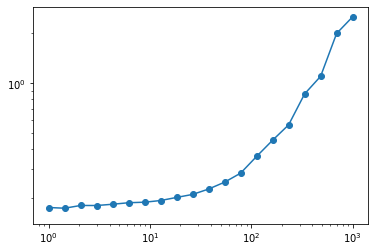

In [43]:
plt.scatter(k_ticks, k_timings)
plt.plot(k_ticks, k_timings)
plt.xscale("log")
plt.yscale("log")

In [44]:
k_brute_gpu_timings = k_timings

So already we're down two orders of magnitude, but we want ONE more order of magnitude speed-up!